# Trabalho Prático 2: Portuguese POS Tagging


## 1. Introdução

O objetivo deste trabalho foi propor e avaliar um modelo para a tarefa de POS Tagging utilizando uma base de dados com textos escritos na língua Portuguesa. A tarefa de POS Tagging consiste da classificação de palavras em uma sentença ou texto quanto a sua classe gramatical, como adjetivo, verbo, preposição, entre outras. Para compreender um texto ou uma sentença é preciso considerar as palavras anteriores. Além disso, para identificar certas ambiguidades na atribuição de classes gramaticais às palavras de um texto é necessário também considerar as palavras posteriores à palavra alvo. Sendo assim, para a implementação do modelo foi utilizada uma rede neural bidirecional do tipo LSTM. A LSTM (Long Short-Term Memory) é uma rede neural recorrente capaz de guardar informações por um longo período de tempo. Com uma LSTM Bidirecional podemos obter informações de estados passados e estados futuros simultaneamente, dessa forma conseguimos utilizar o texto ao redor de uma palavra alvo para prever a classe gramatical da palavra alvo. 

Neste trabalho foi utilizado o corpus Mac-Morpho, produzido pelo grupo NILC da ICMC USP (http://nilc.icmc.usp.br/macmorpho/macmorpho-v3.tgz). O modelo foi criado utilizando o auxilio da biblioteca Keras, e foi testado com a variação de alguns hiperparâmetros e os resultados obtidos foram reportados através de uma comparação da precisão do modelo na predição de cada classe gramatical. Neste notebook está incluído o código usado para o aprendizado do modelo de POS Tagging com a variação dos hiperparâmetros, a explicação das decisões tomadas, os resultados obtidos e as respectivas análises.


In [1]:
## Imports necessários
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sns
sns.set()
sns.set_palette("tab10")


Using TensorFlow backend.


In [2]:
## Caminho para os arquivos de treino, teste e validação
file_train = 'data/macmorpho-train.txt'
file_test = 'data/macmorpho-test.txt'
file_val = 'data/macmorpho-dev.txt'

## 2. Pré-processamento

O primeiro ponto que devemos nos preocupar quando temos uma tarefa como essa é preparar os dados para entrada do modelo. O corpus Mac-Morpho utilizado contém sentenças, não correlacionadas, escritas em português e seguindo uma formatação do tipo: 

`A_ART Apinco_NPROP destaca_V em_PREP seu_PROADJ boletim_N mensal_ADJ que_KS o_ART setor_N avícola_ADJ está_V otimista_ADJ com_PREP o_ART atual_ADJ programa_N de_PREP estabilização_N econômica_ADJ ._PU`

Em que temos a formatação `Palavra_TAG`. Então, o primeiro passo do pré-processamento foi separar as sentenças entre palavras e tags, isso foi feito para todas as bases (treino, teste e validação) utilizando a função `pre-processing` abaixo:

In [3]:
def pre_processing(fname, train=False):
    with open(fname, 'r') as text:
        lines = text.readlines()

    sentences_words = []
    sentences_tags = []
    for l in lines:
        sentence = l.replace('\n', '').split(' ')
        words_token = []
        tags_token = []
        for s in sentence:
            word_tag = s.split('_')
            words_token.append(word_tag[0])
            tags_token.append(word_tag[1])
        sentences_words.append(words_token)
        sentences_tags.append(tags_token)
        
    if train:
        return create_dict_to_numbers(sentences_words, sentences_tags)
    
    return sentences_words, sentences_tags

O modelo criado precisa que os dados de entrada estejam codificados em números, não palavras e classes. Então, a segunda etapa do pré-processamento foi assinalar para cada palavra (e classe) um inteiro como identificador. Na função `create_dict_to_number` foi criado um dicionário para codificar cada palavra e cada classe um valor diferente, e para tal as palavras foram transformadas para minúsculas. Foi adicionado também um valor especial para palavras desconhecidas (--not-exist--), e outro para preenchimento das sequências (--padding--).

A ideia é que esse dicionário irá mapear apenas as palavras que apareceram na base de treinamento. Assim, ao codificar as bases de teste e validação para números, as palavras que não apareceram no treino serão marcadas como palavras desconhecidas. A conversão para números foi feita na função `convert_to_numbers`.

In [4]:
def create_dict_to_numbers(sentences_words, sentences_tags):
    word2number = {}
    tag2number = {}
    
    i = 2
    for s in sentences_words:
        for word in s:
            if word.lower() not in word2number.keys():
                word2number[word.lower()] = i
                i+=1
    word2number['--padding--'] = 0
    word2number['--not-exist--'] = 1
    
    i = 1
    for s in sentences_tags:
        for tag in s:
            if tag not in tag2number.keys():
                tag2number[tag] = i
                i+=1
    tag2number['--padding--'] = 0
    
    return sentences_words, sentences_tags, word2number, tag2number

def convert_to_numbers(sentences_words, sentences_tags, word2number, tag2number):
    sentences_X, sentences_Y = [], []
    
    for s in sentences_words:
        aux_sent = []
        for w in s:
            try:
                aux_sent.append(word2number[w.lower()])
            except:
                aux_sent.append(word2number['--not-exist--'])
        sentences_X.append(aux_sent)
        
    for s in sentences_tags:
        sentences_Y.append([tag2number[t] for t in s])
    
    return sentences_X, sentences_Y

## 3. Modelo de POS Tagging

Nesta seção irei detalhar um pouco mais sobre a arquitetura do modelo criado. Como dito anteriormente, foi utilizada a biblioteca Keras para criar a arquitetura do modelo, de forma que uma das camadas será uma LSTM Bidirecional. Foram treinados modelos com 3 batch sizes diferentes: 64, 128 e 256, bem como foram treinadas 3 quantidades de épocas: 1, 2 e 3. Não foi possível executar por muitas épocas devido ao custo computacional envolvido, entretanto, os resultados obtidos com apenas poucas execuções já foi bastante positivo. 

Para a construção do método é necessário detalhar um pouco sobre o processo de preenchimento das sentenças e as métricas criadas, para então explicar as camadas existentes na arquitetura. 


### 3.1. Adicionar Padding

Para utilizar como entrada para o modelo é necessário que todas as sequências tenham o mesmo tamanho. Sendo assim, será computado o tamanho da maior sequência entre as bases de dados de treino, teste e validação, e esse valor será utilizado para setar o tamanho fixo das sequências de todas as bases. Para setar esse tamanho fixo foi setado utilizando a ideia de `padding` (preenchimento). As sequências então foram preenchidas com o valor 0 como foi indexado no dicionário criado anteriomente através do valor especial `--padding--`. Isso foi feito tanto para as sequências de palavras quando as de classes na função `padding_sequences` abaixo. 

Além disso, também é necessário transformar as sequências de classes, que estão convertidas em números, para sequências de classes codificadas através do método `One-Hot Enconding`. Dessa forma, cada classe será representada como um vetor de 27 posições (26 classes gramaticais + 1 posição referente ao padding) contendo valor 1 apenas na posição referente a classe. Essa transformação é necessária visto que é assim que a camada `Dense` que será utilizada retorna os resultados. 

In [5]:
def one_hot_encoding_tags(sentences_tags, tag2number):
    sentences_Y = []
    
    for s in sentences_tags:
        s_categories = []
        for t in s:
            tags = np.zeros(len(tag2number)) 
            tags[t] = 1
            s_categories.append(tags)
        sentences_Y.append(s_categories)
    
    return sentences_Y

def padding_sequences(sequences_words, sequences_tags, MAX_LENGTH, tag2number):
    sequences_words = pad_sequences(sequences_words, maxlen=MAX_LENGTH, padding='post')
    sequences_tags = pad_sequences(sequences_tags, maxlen=MAX_LENGTH, padding='post')
    
    sequences_tags = one_hot_encoding_tags(sequences_tags, tag2number)
    return sequences_words, np.array(sequences_tags)


### 3.2. Métricas

É necessário também criar as métricas que queremos avaliar, pois as métricas já construídas no Keras são utilizadas apenas para todas as classes. Então, para conseguir obter os resultados das métricas por classe foram criadas as funções `precision`, `recall` e `accuracy` abaixo.

Além disso, para a maioria das sentenças, a maior parte é composta por `padding tokens`. Por conta disso, essa parte da sentença é muito fácil de predizer, e isso acaba aumentando a performance geral do método. Então, foi criada também a função `ignore_pad_acc` para customizar a acurácia geral do modelo ignorando a classe de padding.

É importante lembrar que a acurácia para cada classe não é uma métrica muito boa, pois estamos trabalhando com mais do que duas classes. A acurácia leva em conta os `true negativos`, mas como trabalhamos com mais de duas classes nessa tarefa, os `true negativos` por classe vão considerar como verdade tudo que foi predito como outra classe diferente. Entretanto, isso leva a um resultado alto de acurácia para cada classe que não é condizente com o esperado. Sendo assim, para a análise de resultados neste trabalho foi considerada apenas a precisão por classe, que é uma métrica mais condizente pois leva em conta a porcentagem dos resultados retornados que foi relevante. 

In [6]:
def ignore_pad_acc(to_ignore=0):
    ## ignorar a classe 0, referente ao padding, para computar a acurácia total
    def ignore_padding_accuracy(y_true, y_pred):
        y_true_ids = K.argmax(y_true, axis=-1)
        y_pred_ids = K.argmax(y_pred, axis=-1)
 
        padding_mask = K.cast(K.not_equal(y_pred_ids, to_ignore), 'int32')
        matches_without_padding = K.cast(K.equal(y_true_ids, y_pred_ids), 'int32') * padding_mask
        accuracy = K.sum(matches_without_padding) /  K.maximum(K.sum(padding_mask), 1)
        
        return accuracy
    
    return ignore_padding_accuracy

def precision(id_of_interest):
    ## precisão por classe, pega a porcentagem dos acertos dentre as predições para a classe
    def class_precision(y_true, y_pred):
        y_true_ids = K.argmax(y_true, axis=-1)
        y_preds_ids = K.argmax(y_pred, axis=-1)
        
        retrieved_mask = K.cast(K.equal(y_preds_ids, id_of_interest), 'int32') # tp+fp
        class_true_positive = K.cast(K.equal(y_true_ids, y_preds_ids), 'int32') * retrieved_mask # tp
        class_prec = K.sum(class_true_positive) /  K.maximum(K.sum(retrieved_mask), 1) # tp / tp+fp
        
        return class_prec
    
    return class_precision

def recall(id_of_interest):
    ## revocação por classe, pega a porcentagem dos acertos dentre os valores esperados para a classe 
    def class_recall(y_true, y_pred):
        y_true_ids = K.argmax(y_true, axis=-1)
        y_preds_ids = K.argmax(y_pred, axis=-1)
        
        relevant_mask = K.cast(K.equal(y_true_ids, id_of_interest), 'int32') # tp+fn
        class_true_positive = K.cast(K.equal(y_true_ids, y_preds_ids), 'int32') * relevant_mask # tp
        class_rec = K.sum(class_true_positive) /  K.maximum(K.sum(relevant_mask), 1) # tp / tp+fn
        
        return class_rec
    
    return class_recall


def accuracy(id_of_interest):
    ## acurácia por classe
    def class_accuracy(y_true, y_pred):
        y_true_ids = K.argmax(y_true, axis=-1)
        y_preds_ids = K.argmax(y_pred, axis=-1)

        positive_mask = K.cast(K.equal(y_preds_ids, id_of_interest), 'int32') # tp+fp
        class_true_positive = K.cast(K.equal(y_true_ids, y_preds_ids), 'int32') * positive_mask # tp
        
        negative_mask = K.cast(K.not_equal(y_preds_ids, id_of_interest), 'int32') # tn+fn
        class_true_negative = K.cast(K.equal(y_true_ids, y_preds_ids), 'int32') * negative_mask # tn
        
        tp_sum_tn = K.sum(class_true_positive) + K.sum(class_true_negative)
        sum_all =  K.maximum(K.sum(positive_mask) + K.sum(negative_mask), 1)
        
        return tp_sum_tn / sum_all
    
    return class_accuracy

### 3.3. Arquitetura do Modelo

Então, agora temos a definição da arquitetura do modelo. Foram utilizadas as seguintes camadas:

* `InputLayer`: Camada para ser usada como ponto de entrada em uma rede. Através dela passamos o tamanho da entrada que serão vetores de tamanho igual a MAX_LENGTH (tamanho da maior sequência).
* `Embedding Layer`: Essa camada computa um vetor de palavras para as palavras nas sequências de entrada. Como dmensão de entrada para essa camada temos a quantidade de palavras distintas existentes na base de treino e como dimensão de saída escolhi 128.
* `LSTM Layer com modificador Bidirecional`: Como dito anteriormente, a LSTM será a camada central desse modelo, ela irá aprender as relações entre as palavras nas sentenças. Normalmente, uma camada LSTM utiliza das informações passadas para a próxima predição. Então, o uso do modificador bidirecional faz com que os valores seguintes na sequência também sirvam de entrada para a LSTM, não apenas os anteriores. O parâmetro `return_sequences` foi setado para True, para que seja retornado uma sequência não apenas o valor final. E a dimensionalidade do espaço de saída dessa camada foi setada para 256.
* `Dense Layer (ou fully-connected layer)`: Necessária para escolher a POS Tag apropriada. Como essa camada precisa ser executada em cada elemento da sequência, foi adicionado o modificador `TimeDistributed` que permite aplicar uma camada a cada fatia temporal de uma entrada.
* `Activation Layer`: Aplica a função de ativação softmax na saída que normaliza a saída da rede para uma distribuição de probabilidade entre as classes preditas. 

In [7]:
def create_model(MAX_LENGTH, tag2number, word2number):
    model = Sequential()
    model.add(InputLayer(input_shape=(MAX_LENGTH, )))
    model.add(Embedding(len(word2number), 128))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(TimeDistributed(Dense(len(tag2number))))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer ='rmsprop',
                  metrics=['accuracy', ignore_pad_acc(0), accuracy(0), accuracy(1), accuracy(2), 
                          accuracy(3), accuracy(4), accuracy(5), accuracy(6), accuracy(7), accuracy(8), 
                          accuracy(9), accuracy(10), accuracy(11), accuracy(12), accuracy(13), accuracy(14), 
                          accuracy(15), accuracy(16), accuracy(17), accuracy(18), accuracy(19), accuracy(20), 
                          accuracy(21), accuracy(22), accuracy(23), accuracy(24), accuracy(25), accuracy(26), 
                          precision(0), precision(1), precision(2), precision(3), precision(4), precision(5), 
                          precision(6), precision(7), precision(8), precision(9), precision(10), precision(11),
                          precision(12), precision(13), precision(14), precision(15), precision(16), 
                          precision(17), precision(18), precision(19), precision(20), precision(21), 
                          precision(22), precision(23), precision(24), precision(25), precision(26)])
 
    return model

### 3.4. Execução

Abaixo foi criada uma função para auxiliar a salvar os resultados obtidos para cada época e cada tamanho de batch.

In [8]:
def get_key_from_value(d, val):
    return [k for k, v in d.items() if v == val]

def save_results(scores, batch_size, epochs, tag2number):
    
    if not os.path.exists('results/'):
        os.makedirs('results/')
        
    fname = str(batch_size)+'_'+str(epochs)
    
    with open('results/geral_acc_'+fname+'.csv', 'w') as f:
        f.write('batch_size,epochs,loss,acc\n')
        f.write(str(batch_size)+','+str(epochs)+','+str(scores[0])+','+str(scores[2])+'\n')

    with open('results/acc_class_'+fname+'.csv', 'w') as f:
        f.write('batch_size,epochs,tag,accuracy\n')

    with open('results/precision_class_'+fname+'.csv', 'w') as f:
        f.write('batch_size,epochs,tag,precision\n')

    for i, s in enumerate(scores):    
        if i > 2 and i < 30:
            with open('results/acc_class_'+fname+'.csv', 'a+') as f:
                f.write(str(batch_size)+','+str(epochs)+','+str(get_key_from_value(tag2number, i-2-1)[0])+','+str(s)+'\n')
        if i >= 30:
            with open('results/precision_class_'+fname+'.csv', 'a+') as f:
                f.write(str(batch_size)+','+str(epochs)+','+str(get_key_from_value(tag2number, i-29-1)[0])+','+str(s)+'\n')

Abaixo temos o código para execução dos pré-processamentos e adição de padding nas sequências de todas as três bases de dados (treino, teste e validação).

In [9]:
train_words, train_tags, word2number, tag2number = pre_processing(file_train, train=True)
train_X, train_Y = convert_to_numbers(train_words, train_tags, word2number, tag2number)

test_words, test_tags = pre_processing(file_test)
test_X, test_Y = convert_to_numbers(test_words, test_tags, word2number, tag2number)

val_words, val_tags = pre_processing(file_val)
val_X, val_Y = convert_to_numbers(val_words, val_tags, word2number, tag2number)

print('Pre-Processing Done.')

MAX_LENGTH = max(max(len(max(train_X, key=len)), len(max(val_X, key=len))), len(max(test_X, key=len)))
print('Max Length of sentences: {}'.format(MAX_LENGTH))

train_X, train_Y = padding_sequences(train_X, train_Y, MAX_LENGTH, tag2number)
test_X, test_Y = padding_sequences(test_X, test_Y, MAX_LENGTH, tag2number)
val_X, val_Y = padding_sequences(val_X, val_Y, MAX_LENGTH, tag2number)

print('Padding Done.')

Pre-Processing Done.
Max Length of sentences: 248
Padding Done.


Após ter os dados no formato adequado para dar entrada no modelo, o modelo foi criado e foram executadas diferentes combinações de batch sizes e epochs para o treinamento, de forma que:

* `Batch Sizes`: Variou nos valores de 64, 128 e 256.
* `Epochs`: Variou nos valores de 1, 2 e 3.

Não foram executados mais testes por conta do custo computacional envolvido. 

O corpus de validação foi utilizado na etapa de fit do modelo. Após o treinamento, usamos a base de teste para executar a avaliação do modelo, contabilizando a acurácia total e a precisão e acurácia por classe.


In [10]:
model = create_model(MAX_LENGTH, tag2number, word2number)

batch_sizes = [64, 128, 256] 
epochs = [1, 2, 3]

for e in epochs:
    for bs in batch_sizes:
        model.fit(train_X, train_Y, verbose=0, batch_size=bs, epochs=e, validation_data=(val_X, val_Y))
        print(f'Model training with batch size {bs} and {e} epochs done.')
        scores = model.evaluate(test_X, test_Y)
        save_results(scores, bs, e, tag2number)

Model training with batch size 64 and 1 epochs done.
9987/9987 [==============================] - 59s 6ms/step


## 4. Resultados Obtidos

Uma forma melhor de visualizar os resultados obtidos é através de gráficos. Sendo assim, abaixo temos as funções utilizadas para a crição dos gráficos a partir dos dados armazenados para cada execução. 

In [11]:
def tags_distribution_graph(tags, base_type):
    count_tags = {}
    for s in tags:
        for t in s:
            try:
                count_tags[t] += 1
            except:
                count_tags[t] = 1
    ordered = {k: v for k, v in sorted(count_tags.items(), key=lambda item: item[1])}
    y_pos = np.arange(len(np.array(list(ordered.keys()))))

    fig, ax = plt.subplots(figsize=(13,9))
    ax.barh(y_pos, ordered.values(), align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(np.array(list(ordered.keys())))

    ax.set_xlabel('Quantidade', fontsize=12)
    ax.set_title(f'Distribuição das Classes na Base de {base_type}', fontsize=14)
    
    for bar, value in zip(ax.patches, list(ordered.values())):
        ax.text(value+max(ordered.values())/100, bar.get_y()+bar.get_height()/2, round(value, 3), color = 'black', ha = 'left', va = 'center') 
    
    plt.xlim(0, max(ordered.values())+max(ordered.values())/10)
 
    plt.show()
    
def plot_general_acc(zoom=False):
    batch_sizes = [64, 128, 256] 
    epochs = [1, 2, 3]
    df = pd.DataFrame()
    for e in epochs:
        for bs in batch_sizes:    
            df_aux = pd.read_csv('results/geral_acc_'+str(bs)+'_'+str(e)+'.csv')
            df = df.append(df_aux, ignore_index=True)
    epoch_1 = df[df['epochs']==1]['acc'].tolist()
    epoch_2 = df[df['epochs']==2]['acc'].tolist()
    epoch_3 = df[df['epochs']==3]['acc'].tolist()

    x = np.arange(len(batch_sizes))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots(figsize=(12,5))
    ax.bar(x - width, epoch_1, width, label='1')
    ax.bar(x, epoch_2, width, label='2')
    ax.bar(x + width, epoch_3, width, label='3')

    ax.set_ylabel('Acurácia', fontsize=12)
    ax.set_title('Acurácia por tamanho do batch e número de épocas', fontsize=14)
    ax.set_xlabel('Tamanho do Batch', fontsize=12)
    plt.xticks(x, batch_sizes)
    ax.legend(title='Épocas', loc='best')

    plt.grid(which='major', axis='y', zorder=-1.0)
    plt.xlim(-0.5, 2.5)
    if zoom:
        plt.ylim(0.85, 1.0)

    fig.tight_layout()

    plt.show()

def precision_class_graph(bs, e):
    df = pd.read_csv('results/precision_class_'+str(bs)+'_'+str(e)+'.csv')
    df.drop(['batch_size', 'epochs'], axis=1, inplace=True)
    dict_tags_metric = dict(df.values)
    del dict_tags_metric['--padding--']
    ordered = {k: v for k, v in sorted(dict_tags_metric.items(), key=lambda item: item[1])}
    y_pos = np.arange(len(np.array(list(ordered.keys()))))

    fig, ax = plt.subplots(figsize=(13,9))
    ax.barh(y_pos, ordered.values(), align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(np.array(list(ordered.keys())))

    ax.set_xlabel('Precisão', fontsize=12)
    ax.set_title(f'Precisão por Classe - Batch Size {bs} e {e} epochs', fontsize=14)

    for bar, value in zip(ax.patches, list(ordered.values())):
        ax.text(value+0.005, bar.get_y()+bar.get_height()/2, round(value, 3), color = 'black', ha = 'left', va = 'center') 
    
    plt.show()

### Acurácia Geral 

Nos gráficos abaixo podemos observar a acurácia geral do modelo dada as configurações dos parâmetros variados (número de épocas e batch size). No segundo gráfico é possível ver uma ampliação, de forma que o valor da acurácia começa a ser marcado a partir de 0.85, e com isso é possível distinguir melhor o que aconteceu com o modelo nos três tamanhos de batch testados. Podemos ver que o batch size 128 foi o que obteve um melhor resultado para todas as quantidades de épocas. E é também interessante observar como a acurácia caiu para o batch 256 com 2 épocas.  

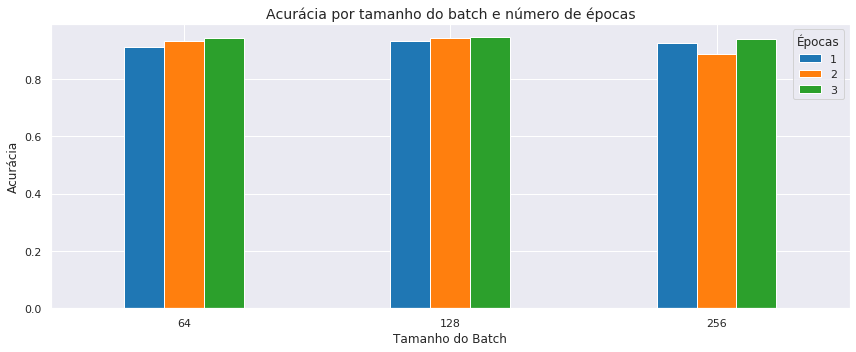

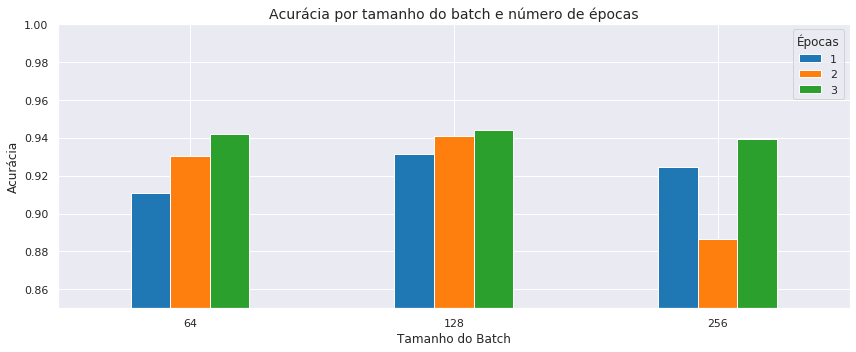

In [12]:
plot_general_acc()
plot_general_acc(zoom=True)

### Precisão por Classe

Agora vamos observar um pouco mais detalhadamente quais foram os resultados das predições quanto às classes gramaticais existentes na base. São 26 classes gramaticais, excluindo o padding. Vamos subdividir as análises entre os tamanhos de batch:

### Batch Size 64 

Considerando uma época e batch size de 64 nós podemos observar que existem duas classes gramaticais com precisão 0 (PREP+AVD e IN), ou seja, não tiveram acertos para essas classes dentre as predições. Podemos perceber também que a classe de pontuações teve uma precisão muito alta, e isso é esperado visto que atribuir a classe de pontuação para uma pontuação é relativamente fácil visto que não existe ambiguidade nessa atribuição. A segunda classe com precisão mais alta é a KC (Conjunção Coordenativa), que são palavras que funcionam como conectivos entre elementos independentes, também parece ser uma classe sem muita ambiguidade. Algumas classes estão mais correlacionadas com ambiguidade como preposições, participio e advérbios, mas podemos observar que a precisão foi boa para elas, sendo um pouco menor (0.821) para a classe Partício (PCP) talvez devido a baixa distribuição na base de dados. Iremos analisar isso mais pra frente.

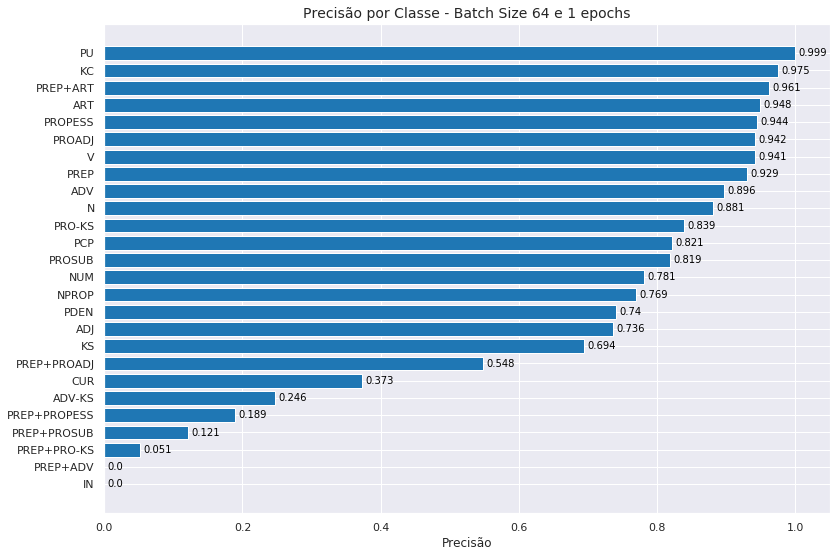

In [13]:
precision_class_graph(64, 1)

Com 2 épocas conseguimos ver que teve uma melhoria na predição de muitas classes. Por exemplo, a classe KS (Conjunção Subordinativa) que estava com 0.694 de precisão no gráfico acima, passou para 0.843 de precisão no gráfico abaixo. Podemos ver também que as 8 últimas classes permaneceram as mesmas, ocorrendo algumas trocas de ordem e um aumento pequeno na precisão. Mas isso pode indicar que essas classes não foram muito bem representadas no treino e por isso é mais difícil de realizar a predição delas. 

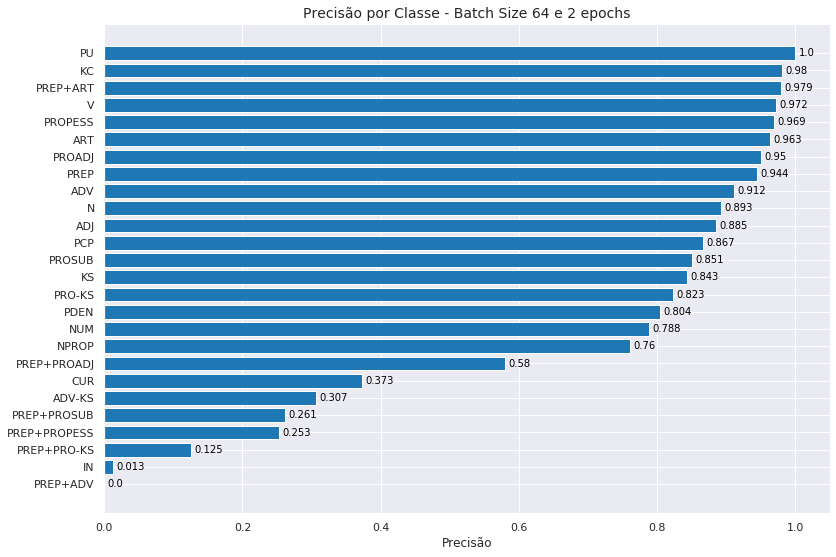

In [14]:
precision_class_graph(64, 2)

Novamente a gente observa um aumento da precisão das 18 primeiras classes dado o aumento do número de épocas. Podemos ver que a classe PREP+ADV que possuia precisão 0 nas duas últimas épocas saiu do zero aqui, mas ainda revela uma quantidade de acertos muito baixa por parte do modelo para essa classe.

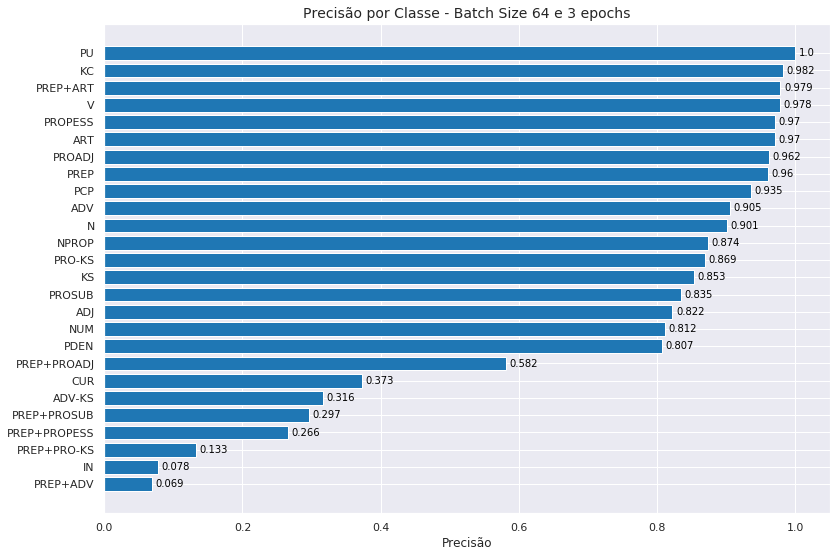

In [15]:
precision_class_graph(64, 3)

### Batch Size 128

Podemos perceber que o modelo treinado com batch de 128 e 1 época possui resultados similares ao modelo treinado com batch 64 e 2 épocas. De forma que, as 8 primeiras classes mantiveram a mesma ordem entre essas duas execuções. Novamente podemos fazer as mesmas observações sobre a classe de pontuações (PU) ter uma precisão muito alta, pois realmente é fácil predizer pontuação visto que não há ambiguidade nisso. As 8 últimas classes gramaticais no ranking se mantiveram as mesmas, reforçando a ideia de que faltam dados sobre elas no treino. 

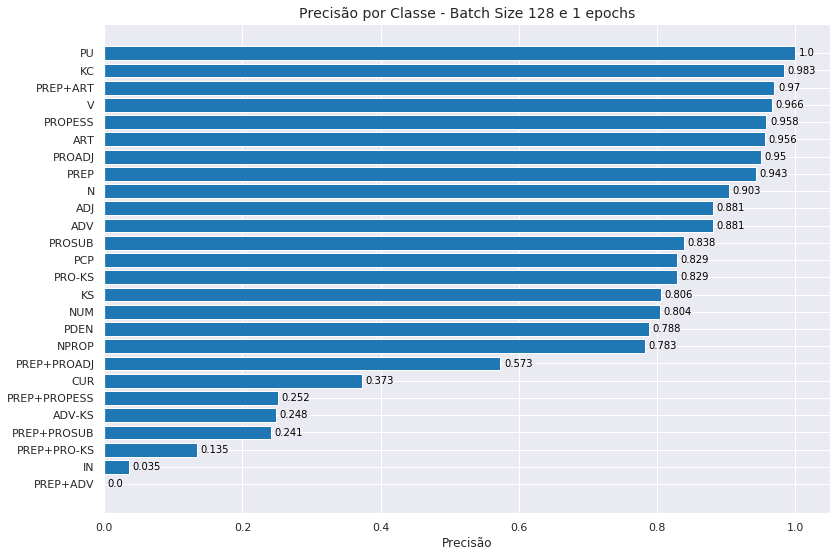

In [16]:
precision_class_graph(128, 1)

As mesmas observações sobre as últimas classes no ranking podem ser vistas no gráfico abaixo com 2 épocas. Podemos ver que a precisão cresceu para algumas classes em comparação com gráfico anterior. Porém, a ordem das primeiras classes foi alterada e a precisão para KC (Conjunção Coordenativa) caiu um pouco de 0.983 para 0.976.

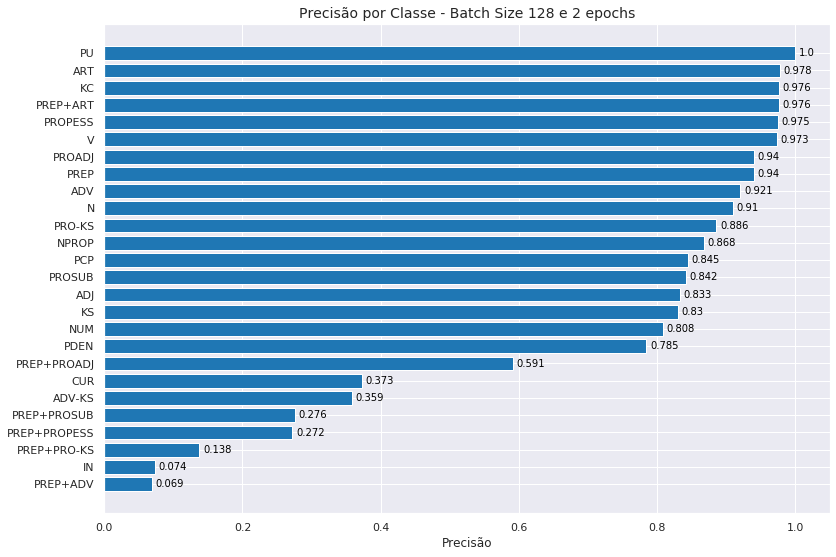

In [17]:
precision_class_graph(128, 2)

Agora com 3 épocas a gente volta a observar a mesma ordem entre as primeiras classes no ranking que existia usando batch 128 de 1 época, de forma que a classe KC volta a estar em segunda posição. Ocorreu um aumento na precisão da maioria das classes, mas as observações iniciais acerca do treinamento com batch 64 podem ser observadas aqui também. 

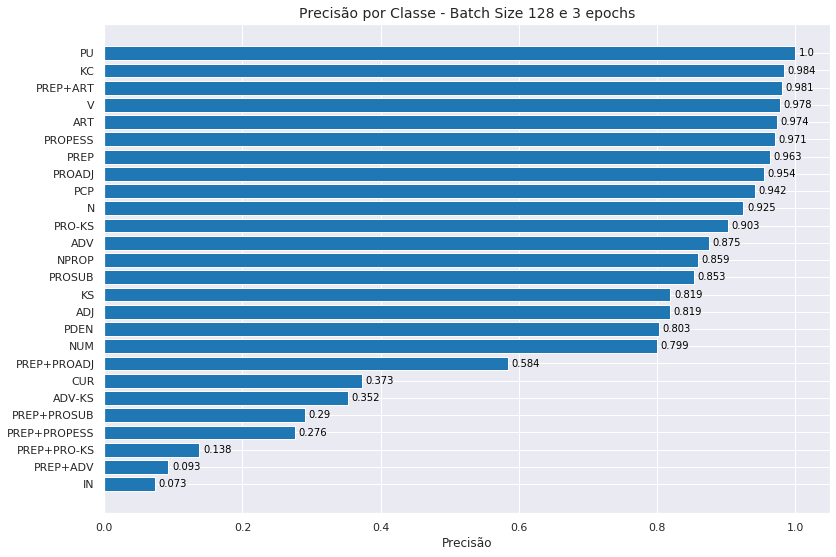

In [18]:
precision_class_graph(128, 3)

### Batch 256

Um resultado curioso observado anteriormente é que com 2 épocas e batch size 256 o método obteve uma acurácia geral inferior a todos os outros conjuntos de parâmetros testados. Nesta seção vamos tentar observar isso um pouco melhor. Mas antes, primeiramente vamos olhar para o gráfico de batch 256 e 1 época. Podemos ver que agora, diferentemente de todos os outros gráficos, nós tivemos a classe V (Verbo) com a segunda maior precisão. Nas análises anteriores a classe V apareceu no máximo em quarto lugar. Outra diferença é que a classe N (Nome) não havia aparecido em uma posição tão alta no ranking antes. 

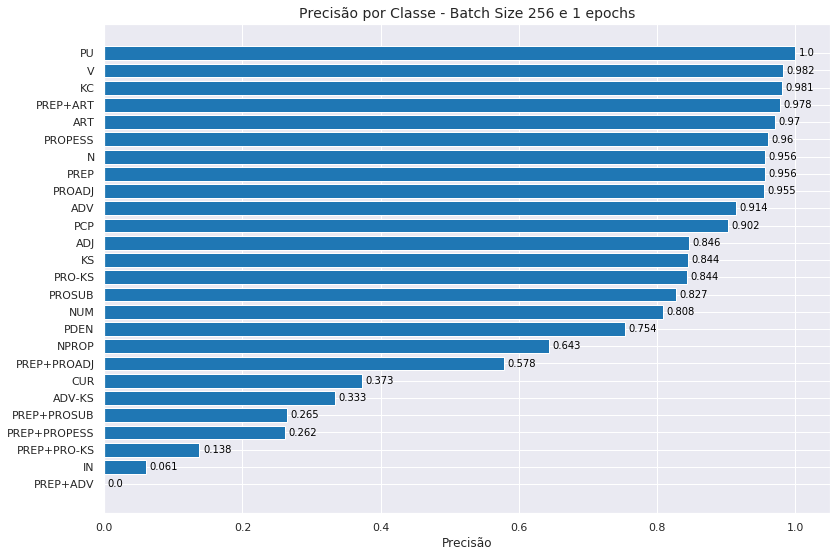

In [19]:
precision_class_graph(256, 1)

Com 2 épocas podemos ver que algo estranho aconteceu, classes que antes tiveram uma precisão pequena passaram a ter precisão 0 (PREP+PRO+KS e PREP+PROPESS). Como essas classes anteriormente não tiveram precisão alta em nenhum momento pode ser que a presença delas no treino seja muito pequena e talvez o tamanho do batch maior possibilitou que outra classe fosse predita para essas classes, e o número maior de épocas pode ter afetado também dado a etapa de validação. Porém, esse resultado é bastante curioso visto que ao utilizar 3 épocas voltamos a predizer uma precisão maior que zero para essas classes, como será visto a seguir.

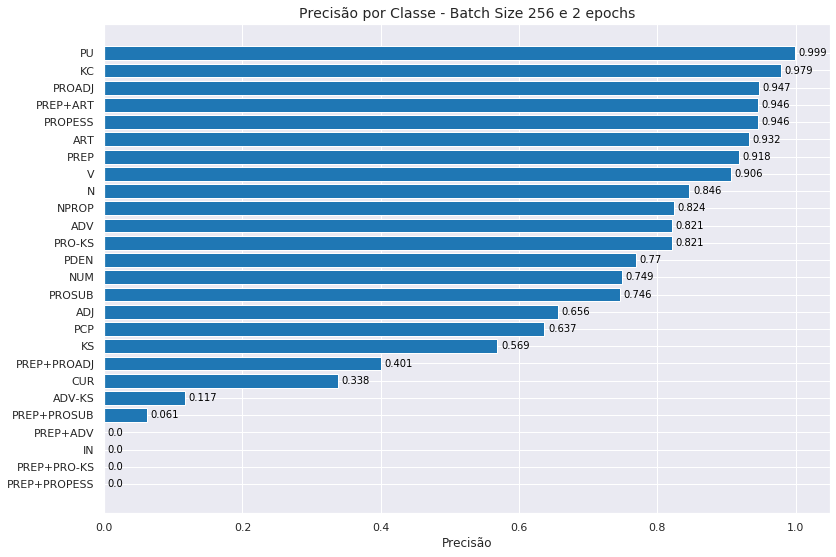

In [20]:
precision_class_graph(256, 2)

Com 3 épocas todas as classes que estavam com precisão 0 anteriormente passaram a ter um valor de precisão baixo, mas diferente de 0. Essa ocorrência foi inesperada, não consegui interpretar muito bem o que aconteceu nesse passo do treinamento. Entretanto, podemos ver abaixo que para 3 épocas tudo voltou a seguir o mesmo padrão que aconteceu nos outros batches. Uma diferença é que a classe PREP+ART que aparecia em terceira posição enteriormente, aqui é a segunda com precisão mais alta. Já a classe KC que antes aparecia em segundo aqui apareceu em quarto. 

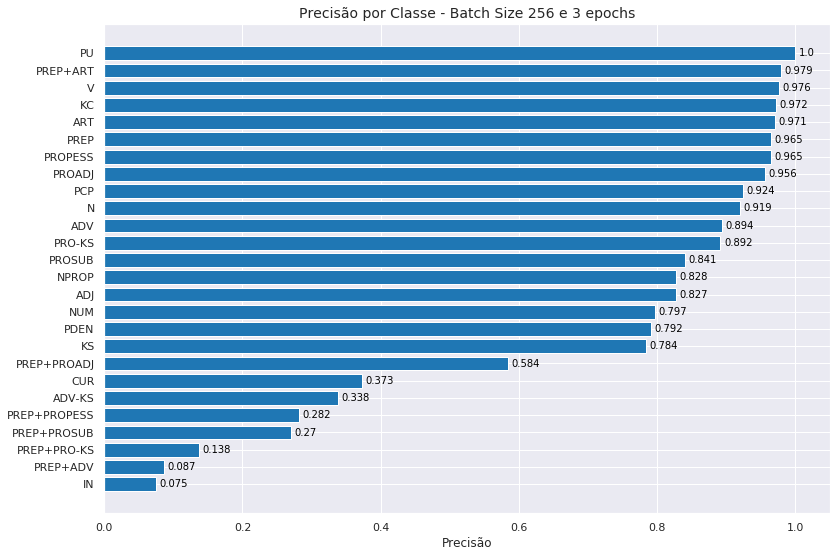

In [21]:
precision_class_graph(256, 3)

No geral podemos observar que consistentemente as classes pontuação (PU), preposição + artigo (PREP+ART), verbo (V) e KC (Conjunção Coordenativa) possuiram precisão alta independentemente do número de épocas e do tamanho do batch. Isso pode ser entendido como alta presença dessas classes gramaticais na base de treinamento ou podem ser classes que criam menos ambiguidades na linguagem também. 

### Distribuição das Classes

Agora vamos analisar a distribuição das classes na base de treino e de teste para verificar se os arugmentos utilizados anteriormente para justificar o valor de precisão para cada classe são condizentes. Primeiramente, podemos observar que a base é desbalanceada, de forma que algumas classes aparecem muito mais que outras. Mas isso é natural visto que ocorre também na língua portuguesa, nós utilizamos muito mais recorrentemente em textos nomes (N), verbos (N), preposições (PREP), artigos (ART), pontuações (PU), entre outros. As últimas 8 classes, tanto no treino quanto no teste, são as mesmas que apresentaram menores valores de precisão em todas as combinações de batch size e número de épocas. E é claro que a quantidade de vezes que essas classes aparecem na base de dados influencia no quão bem o modelo irá prever a classe. A classe preposição + advérbio (PREP+ADV) aparece apenas 50 vezes no treino, isso dificulta muito para o modelo aprender. 

Outra coisa que podemos observar é que a classe KC (Conjunção Coordenativa) não é uma das que mais aparece na base de dados, entretanto, foi uma das classes que possuiu precisão mais alta em todos os testes realizados. Provavelmente, essa é uma classe gramatical que não gera muita ambiguidade textual e que seja fáicl de predizer. Por fim, note que a classe nomes (N) é a que mais aparece na base de dados, porém não esteve entre as primeiras com precisão mais alta nos testes. A posição mais alta no ranking de classes que a classe nome (N) apareceu foi em sétimo, utilizando batch size 256 e 1 época. Possivelmente, essa classe é alvo de muita ambiguidade na base utilizada, ela pode ser confundida com a classe verbo, por exemplo:

    O seu olhar_N era radiante.
    Seu andar_N era desinibido.
    
As palavras `olhar` e `andar` devem aparecer mais como verbos na base de dados do que como nomes. Talvez, por conta disso, a predição para essa classe não foi a mais alta mesmo tendo tantos exemplos na base, apesar de que os valores obtidos para a classe N já estavam por volta de 0.95 que é um resultado muito bom.

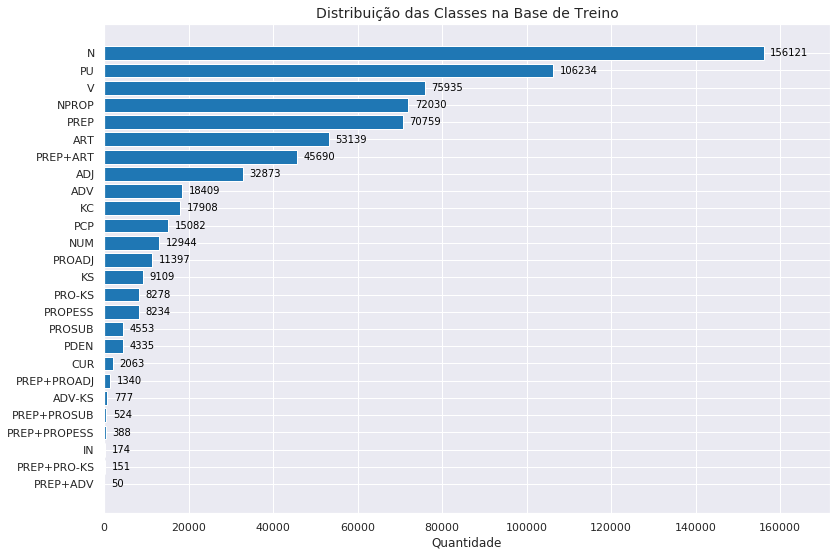

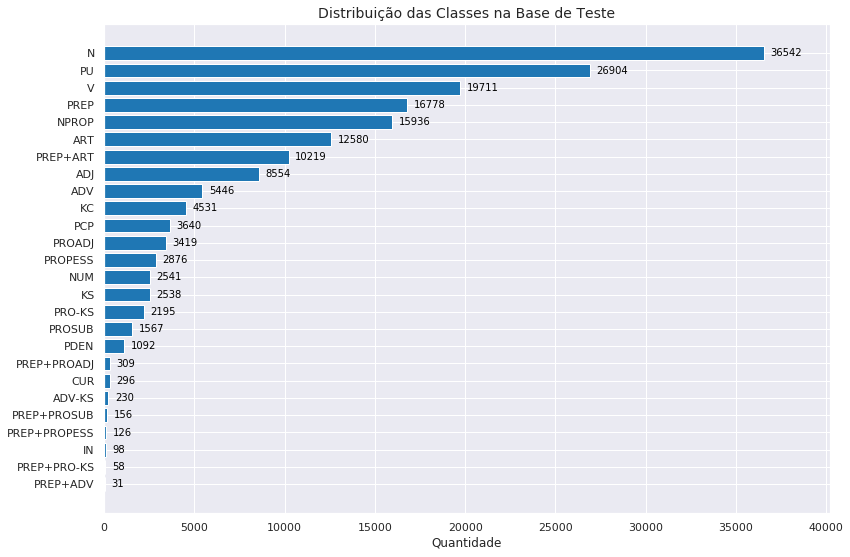

In [22]:
tags_distribution_graph(train_tags, "Treino")
tags_distribution_graph(test_tags, "Teste")

## 5. Conclusão

Neste trabalho foi possível realizar a implementação de um modelo de POS Tagging utilizando uma LSTM Bidirecional. Para tal, foram utilizados 3 tamanhos de batch e 3 números de épocas diferentes. Os melhores resultados foram obtidos pelo modelo utilizando um batch size de 128 e 3 épocas. Todos os resultados obtidos, explorados na seção 4, foram bastante relevantes e condizentes com a base de dados utilizada. Foi feita uma análise da acurácia geral do método, para cada parâmetro variado, bem como uma análise da precisão para cada classe gramatical separadamente. No final, foi possível interpretar os resultados com base na distribuição das classes no treino e no teste. Foi possível perceber que a classe nome (N) provavelmente possui bastante ambiguidade e a classe conjunção coordenativa (KC) parece possuir pouca. 

Esse trabalho foi interessante pois com ele foi possível entender na prática como é feita a avaliação e a criação de um modelo de POS Tagging, bem como buscar interpretações para as diferenças encontradas e poder entender mais como os estudos teóricos feitos em aula se aplicam nos dados. O tempo computacional gasto para o treinamento dos modelos foi alto, o que impediu a realização de outros experimentos variando mais os parâmetros. Mas acredito que com tudo que foi feito nesse notebook foi possível colocar em prática os conhecimentos de sala de aula e atender ao propósito do trabalho de maneira satisfatória.